In [19]:
import sklearn
import glob
import pickle
import os
import cv2
import numpy as np
import skimage
from skimage import data, color, exposure
from PIL import Image
import matplotlib.pyplot as plt
from collections import deque
from scipy.ndimage.measurements import label
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, Flatten, Input, Conv2D, MaxPooling2D, Lambda
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.transform import resize

KERAS_BACKEND=tensorflow
print("Modules imported")

Modules imported


## Creating and splitting the training data

In [11]:
X  = []

cars = glob.glob("./data/vehicles/*/*.png")
non_cars = glob.glob("./data/non-vehicles/*/*.png")

for car in cars:
    X.append(skimage.io.imread(car))

for non_car in non_cars:
    X.append(skimage.io.imread(non_car))

X = np.array(X)
# assign according image labels
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 4)

print('X_train:', X_train.shape)
print('X_test', X_test.shape)
print('y_train:', y_train.shape)
print('y_test', y_test.shape)

X_train: (6592, 64, 64, 3)
X_test (733, 64, 64, 3)
y_train: (6592,)
y_test (733,)


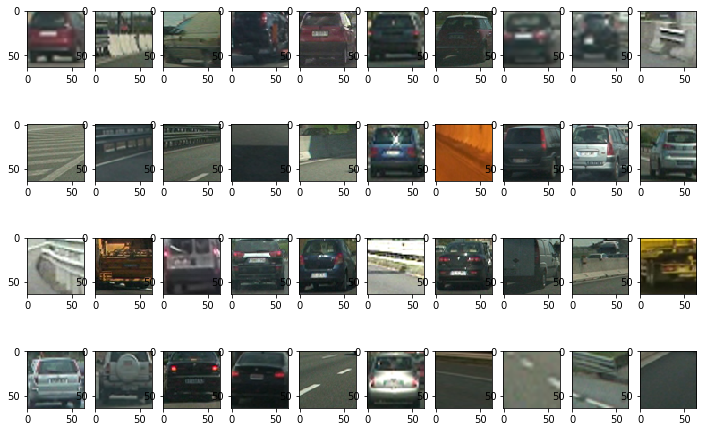

In [12]:
def showRandomImages():
    fig = plt.figure(figsize=(12,8))
    for i in range(0, 40):
        number = np.random.randint(0, len(X_train))
        axis = fig.add_subplot(4, 10, i + 1)
        axis.imshow(X_train[number])
    plt.show()

showRandomImages()

Training car examples quantity 3504
Training non-car examples quantity 3088
Testing car examples quantity 396
Testing non-car examples quantity 337


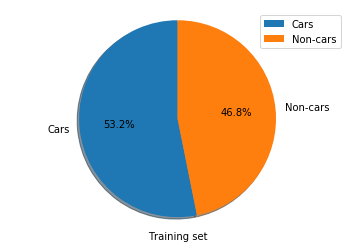

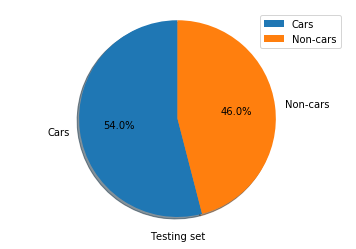

In [13]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
training_unique, training_counts = np.unique(y_train, return_counts = True)
test_unique, test_counts = np.unique(y_test, return_counts = True)
sizes = [training_counts, test_counts]

training_car_quantity = training_counts[0]
training_non_car_quantity = training_counts[1]

test_car_quantity = test_counts[0]
test_non_car_quantity = test_counts[1]

print('Training car examples quantity', training_car_quantity)
print('Training non-car examples quantity', training_non_car_quantity)
print('Testing car examples quantity', test_car_quantity)
print('Testing non-car examples quantity', test_non_car_quantity)

labels = ['Cars', 'Non-cars']
training_sizes = [training_car_quantity, training_non_car_quantity]
test_sizes = [test_car_quantity, test_non_car_quantity]


fig1, ax1 = plt.subplots()
ax1.pie(training_sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.xlabel('Training set')
plt.legend()
plt.show()

fig2, ax2 = plt.subplots()
ax2.pie(test_sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.xlabel('Testing set')
plt.legend()
plt.show()

## Building the CNN model

In [16]:
def create_model():
    
    model = Sequential()
    # Center and normalize our data
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape = (64, 64, 3)))
              
    # 1st conv layer with 42 filter, 3x3 each, 50% dropout, output 62x62x1
    model.add(Conv2D(42, (3, 3), subsample=(2, 2), padding='valid', activation='relu', name='conv1'))         
    # output 31x31
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
    model.add(Dropout(0.5))
              
    # 2nd conv layer with 80 filter, 3x3 each, 50% dropout, output 29x29x1
    model.add(Conv2D(80, (3, 3), subsample=(2, 2), padding='valid', activation='relu', name='conv2'))
    model.add(Dropout(0.5))
              
    # 3rd conv layer with 128 filter, 3x3 each, output 14x14x1
    model.add(Conv2D(128, (1, 1), subsample=(2, 2), padding='valid', activation='relu', name='conv3'))
    # output 7x7x1
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
              
    model.add(Flatten())
    model.add(Dense(300, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    
    return model

model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 31, 31, 42)        1176      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 42)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 30, 42)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 80)        30320     
_________________________________________________________________
dropout_11 (Dropout)         (None, 14, 14, 80)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 7, 7, 128)         10368     
__________

## Training the model

Train on 6592 samples, validate on 733 samples
Epoch 1/40
100s - loss: 0.0234 - acc: 0.9713 - val_loss: 0.0243 - val_acc: 0.9754
Epoch 2/40
99s - loss: 0.0197 - acc: 0.9753 - val_loss: 0.0238 - val_acc: 0.9714
Epoch 3/40
99s - loss: 0.0236 - acc: 0.9698 - val_loss: 0.0239 - val_acc: 0.9727
Epoch 4/40
99s - loss: 0.0164 - acc: 0.9804 - val_loss: 0.0317 - val_acc: 0.9618
Epoch 5/40
103s - loss: 0.0191 - acc: 0.9759 - val_loss: 0.0265 - val_acc: 0.9673
Epoch 6/40
103s - loss: 0.0209 - acc: 0.9736 - val_loss: 0.0238 - val_acc: 0.9700
Epoch 7/40
104s - loss: 0.0215 - acc: 0.9747 - val_loss: 0.0373 - val_acc: 0.9523
Epoch 8/40
105s - loss: 0.0182 - acc: 0.9759 - val_loss: 0.0113 - val_acc: 0.9864
Epoch 9/40
106s - loss: 0.0169 - acc: 0.9788 - val_loss: 0.0349 - val_acc: 0.9550
Epoch 10/40
106s - loss: 0.0200 - acc: 0.9747 - val_loss: 0.0147 - val_acc: 0.9823
Epoch 11/40
107s - loss: 0.0176 - acc: 0.9782 - val_loss: 0.0194 - val_acc: 0.9754
Epoch 12/40
108s - loss: 0.0176 - acc: 0.9788 - val_

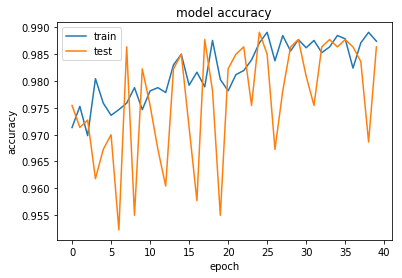

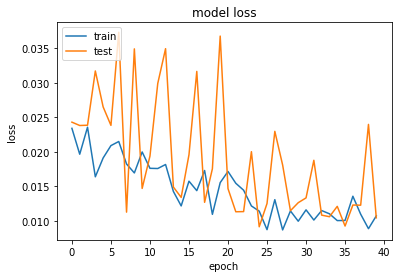

In [21]:
# Plot the results of the training
def plot_results(history):
    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size = 40, nb_epoch=40, verbose=2, validation_data=(X_test, y_test))

plot_results(history)

model.save_weights('model.h5')